# *dandelion* Notebook-1

![dandelion_logo](img/dandelion_logo.png)
## Foreword
***dandelion*** is written in `python==3.7.6` and it is primarily a single-cell BCR-seq analysis package. It makes use of some tools from the fantastic [*immcantation suite*](https://immcantation.readthedocs.io/) and the main idea is that it implements a workflow for the pre-processing and exploratory stages with integrated use of tools from *immcantation* for the BCR side of things and analysis tools from [*scanpy*](https://scanpy.readthedocs.io/) for the RNA-seq side of things. I hope to be able to introduce some new single-cell BCR-seq exploratory tools down the road through *dandelion*. 


## Pre-processing
This notebook will cover the initial pre-processing of files after 10X's `cellranger vdj` immune profiling data analysis pipeline. The directory structure of a 10x output folder will typically look like this:
```console
(dandelion) mib113557i:Pan_Immune_BCR kt16$ tree Pan_T7918901
Pan_T7918901
├── all_contig.fasta
├── all_contig.fasta.fai
├── all_contig_annotations.csv
├── clonotypes.csv
├── concat_ref.fasta
├── concat_ref.fasta.fai
├── consensus.fasta
├── consensus.fasta.fai
├── consensus_annotations.csv
├── filtered_contig.fasta
├── filtered_contig_annotations.csv
└── metrics_summary.csv
```

At this stage, ***dandelion*** needs the fasta files and the cellranger annotation files to start, particularly either *all_contig.fasta* or *filtered_contig.fasta* and corresponding *all_contig_annotations.csv* and *filtered_contig_annotations.csv*.

In this notebook, I'm running everything with the *all_contig* files to get a sense of how long it would take when the files are considerably larger. I'm using a standard laptop for the analysis here: entry level 2017 Macbook Pro with 2.3 GHz Intel Core i5 processor and 16 GB 2133 MHz LPDDR3 ram.

#### Before starting, a couple of environmental variables need to be set up to make it run smoothly:

In ***shell***, export the path to the database folders like as follows:
```bash
echo "export GERMLINE=/Users/kt16/Documents/Github/dandelion/database/germlines/" >> ~/.bash_profile
echo "export IGDATA=/Users/kt16/Documents/Github/dandelion/database/igblast/" >> ~/.bash_profile
echo "export BLASTDB=/Users/kt16/Documents/Github/dandelion/database/blast/" >> ~/.bash_profile
echo "export PATH=/Users/kt16/Documents/Github/dandelion/bin:$PATH" >> ~/.bash_profile
source ~/.bash_profile
```
The databases for igblast are basically setup using [changeo's instructions](https://changeo.readthedocs.io/en/stable/examples/igblast.html). The instruction for setting up blast database is simpler and will be covered later in this notebook.

Also check if the softwares can be found:
```console
(mypython3) mib113557i:~ kt16$ conda activate dandelion
(dandelion) mib113557i:~ kt16$ which makeblastdb
/Users/kt16/Documents/Github/dandelion/bin/makeblastdb
(dandelion) mib113557i:~ kt16$ which blastn
/Users/kt16/Documents/Github/dandelion/bin/blastn
(dandelion) mib113557i:~ kt16$ which igblastn
/Users/kt16/Documents/Github/dandelion/bin/igblastn
(dandelion) mib113557i:~ kt16$ which tigger-genotype.R
/Users/kt16/Documents/Github/dandelion/bin/tigger-genotype.R
```

If you followed the installation instructions, you should have the softwares installed already. Otherwise, you can download them manually: [blast+](https://ftp.ncbi.nih.gov/blast/executables/igblast/release/LATEST/) and [igblast](https://ftp.ncbi.nlm.nih.gov/blast/executables/blast+/LATEST/). For tigger-genotype, you can download it [here](https://bitbucket.org/kleinstein/immcantation/src/default/pipelines/). Just note that I made some minor modifications to this file, hence there's version specific that comes with this package.

This notebook will demonstrate how I batch process multiple samples/files from the same donor, as it will become important for step 4.

In [1]:
# Import modules
import os
os.chdir(os.path.expanduser('/Users/kt16/Documents/Github/dandelion')) # don't need to run this
import dandelion as ddl

/Users/kt16/miniconda3/envs/dandelion/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
# change directory to somewhere more workable
os.chdir(os.path.expanduser('/Users/kt16/Documents/Clatworthy_scRNAseq/Ondrej/PIP/Pan_Immune_BCR/'))
# print current working directory
os.getcwd()

'/Users/kt16/Documents/Clatworthy_scRNAseq/Ondrej/PIP/Pan_Immune_BCR'

### Step 1:
This step immediately below is optional and is just a quick way to make a dictionary from an external file with a utility function `utl.dict_from_table`.

In [3]:
# prepare a dictionary from a meta data file.
sampledict = ddl.utl.dict_from_table('/Users/kt16/Documents/Clatworthy_scRNAseq/Ondrej/dandelion_files/meta/PIP_sampleInfo_kt16.txt', columns = ('SANGER SAMPLE ID', 'GEX_SAMPLE_ID'))
sampledict

{'Pan_T7918887': 'Pan_T7917815',
 'Pan_T7918888': 'Pan_T7917816',
 'Pan_T7918889': 'Pan_T7917817',
 'Pan_T7918890': 'Pan_T7917818',
 'Pan_T7918891': 'Pan_T7917819',
 'Pan_T7918892': 'Pan_T7917820',
 'Pan_T7918893': 'Pan_T7917821',
 'Pan_T7918894': 'Pan_T7917822',
 'Pan_T7918895': 'Pan_T7917823',
 'Pan_T7918896': 'Pan_T7917824',
 'Pan_T7918897': 'Pan_T7917825',
 'Pan_T7918898': 'Pan_T7917826',
 'Pan_T7918899': 'Pan_T7917827',
 'Pan_T7918900': 'Pan_T7917828',
 'Pan_T7918901': 'Pan_T7917815',
 'Pan_T7918902': 'Pan_T7917816',
 'Pan_T7918903': 'Pan_T7917817',
 'Pan_T7918904': 'Pan_T7917818',
 'Pan_T7918905': 'Pan_T7917819',
 'Pan_T7918906': 'Pan_T7917820',
 'Pan_T7918907': 'Pan_T7917821',
 'Pan_T7918908': 'Pan_T7917822',
 'Pan_T7918909': 'Pan_T7917823',
 'Pan_T7918910': 'Pan_T7917824',
 'Pan_T7918911': 'Pan_T7917825',
 'Pan_T7918912': 'Pan_T7917826',
 'Pan_T7918913': 'Pan_T7917827',
 'Pan_T7918914': 'Pan_T7917828',
 'Pan_T7935498': 'Pan_T7935487',
 'Pan_T7935499': 'Pan_T7935488',
 'Pan_T793

#### Formatting the headers of the cellranger fasta file
Here, I'm adding a sample prefix to the headers of each contig in the fasta files using the dictionary created above, via the function `pp.format_fasta(s)`. The prefix is basically just the folder name, so in this case it's `Pan_T7918901`. The function will also create subfolders where the new fasta file and all subsequent files will be located. The function will also add the prefix to the corresponding annotation file automatically and create a copy in the same folder as the formated fasta file. 

This is to ensure that the barcodes are consistent throughout so as not to interfere with subsequent integration with the gene expression data, which will be covered in notebook-2. 

The file structure should look something like this later on if the settings are left as default.
```console
(dandelion) mib113557i:Pan_Immune_BCR kt16$ tree Pan_T7918901
Pan_T7918901
├── all_contig.fasta
├── all_contig.fasta.fai
├── all_contig_annotations.csv
├── clonotypes.csv
├── concat_ref.fasta
├── concat_ref.fasta.fai
├── consensus.fasta
├── consensus.fasta.fai
├── consensus_annotations.csv
├── dandelion
│   └── data
│       ├── all_contig.fasta
│       ├── all_contig_annotations.csv
│       ├── all_contig_igblast_gap.tsv
│       └── tmp
│           └── all_contig_igblast.tsv
├── filtered_contig.fasta
├── filtered_contig_annotations.csv
└── metrics_summary.csv
```

The function `pp.format_fastas` will take two options, first is a list of the fasta files to reformat, and second is a list of the prefixes to add to headers/contig_ids for each sample. If you choose not to provide a prefix, then the function will simply make a copy of the original files and place it in the ***dandelion*** sub-folders.

I'm using a simple list comprehension for both options to simplify the call.

In [4]:
# the first option is a list of fasta files to format and the second option is the prefix to add to each file.
samples = ['Pan_T7918901', 'Pan_T7918902', 'Pan_T7918903', 'Pan_T7918904', 'Pan_T7918905', 'Pan_T7918906', 'Pan_T7918907', 'Pan_T7918908', 'Pan_T7918909', 'Pan_T7918910', 'Pan_T7918912', 'Pan_T7918913', 'Pan_T7918914']
ddl.pp.format_fastas([str(s)+'/all_contig.fasta' for s in samples], [sampledict[s] for s in samples])

Formating fasta(s) : 100%|██████████| 13/13 [00:45<00:00,  3.46s/it]


`pp.format_fastas` (note the plural) is essentially a wrapper for the for-loop below that calls `pp.format_fasta`.
```python
for s in samples:
    filePath = s+'/all_contig.fasta'
    ddl.pp.format_fasta(filePath, sampledict[s])
```

### Step 2:
#### Reannotate the V/D/J genes with *igblastn*.

`pp.reannotate_genes` uses [*changeo*](https://changeo.readthedocs.io/en/stable/examples/10x.html)'s scripts to call *igblastn* to reannotate the fasta files. Depending on the `fileformat` option, it will parse out as either an `airr` (default) or `changeo`-legacy TSV file. Importantly, with the recent update to changeo v1.0.0, all the column headers, including *changeo* format, are now adhereing to the [*AIRR*](http://docs.airr-community.org/) standard (lowercase and some column name changes). Specifying `extended = True` will return the additional 10x annotation of V/D/J genes but they are unnecessary at this stage.

In [5]:
# reannotate the vdj genes with igblastn and parses output to 'airr' (default) or 'changeo' tsv formats using changeo v1.0.0 scripts
ddl.pp.reannotate_genes(samples)

Assigning genes : 100%|██████████| 13/13 [33:56<00:00, 156.62s/it]


### Step 3:
#### Assigning constant region calls

10X's annotation.csv files provides a *c_gene* column, but rather than simply relying on 10x's annotation, [hk6](https://twitter.com/hamish_king) recommended using [*immcantation-presto*'s *MaskPrimers.py*](https://presto.readthedocs.io/en/version-0.5.3---license-change/tools/MaskPrimers.html) with his custom primer list and I tested that; worked well but it took ***20 min*** for the first file (~6k contigs). It also only calls the constant region for the heavy chains. The processing speed for MaskPrimers can be sped up with using the filtered file.

Anyway, as an alternative, I wrote a pre-processing function, `pp.assign_isotype`, to use *blast* to annotate constant region calls for all contigs and retrieves the call, merging it with the tsv files. This function will simply overwrite the output from previous steps and add a *c_call* column at the end, or replace the existing column if it already exists.

To deal with incorrect constant gene calls due to insufficient length, an internal subfunction will run a pairwise alignment against [hk6](https://twitter.com/hamish_king)'s curated sequences that were deemed to be highly specific in distinguishing IGHA1-2, IGHG1-4. I have also curated sets of sequences that should help deal with IGLC3/6/7 as these are problematic too. If there's insufficient info, the `c_call` will be returned as a combination of the most aligned sets of sequences. Because of how similar the light chains are, extremely ambiguous calls (only able to map to a common sequence across the light chains) will be returned as `IGLC`. This typically occurs when the constant sequence is very short. Those that have equal alignment scores between `IGLC3/6/7` sequences and the common sequence will be returned as a concatenated call; for example with a contig initially annotated as `IGLC3` will be returned as `IGLC,IGLC3`. If you do not want this subfunction to run, toggle:

```python
correct_c_call = False
```

The curated sequences can be replaced with a user-provided dictionary via the option `correction_dict`. The provided dictionary should be a nested dictionary like the following:
```python
primer_dict = {
    'IGHG':{
        'IGHG1':'GCCTCCACCAAGGGCCCATCGGTCTTCCCCCTGGCACCCTCCTCCAAGAGCACCTCTGGGGGCACAGCGGCCCTGGGC',
        'IGHG2':'GCCTCCACCAAGGGCCCATCGGTCTTCCCCCTGGCGCCCTGCTCCAGGAGCACCTCCGAGAGCACAGCGGCCCTGGGC',
        'IGHG3':'GCTTCCACCAAGGGCCCATCGGTCTTCCCCCTGGCGCCCTGCTCCAGGAGCACCTCTGGGGGCACAGCGGCCCTGGGC',
        'IGHG4':'GCTTCCACCAAGGGCCCATCCGTCTTCCCCCTGGCGCCCTGCTCCAGGAGCACCTCCGAGAGCACAGCCGCCCTGGGC'}}
```

The key for the first level of the dictionary is used like a grep for searching whether the string pattern exists in the `c_call`, and the second level holds the dictionary for the the sequences to align to. The keys in the second level are used for replacing the existing `c_call` annotation if it is returned with the highest alignment score. The internal function currently only accepts nested dictionaries of any length with a requirement that each of the dictionaries in the second level must be of length 2 to 4; the example above is a nested dictionary of length 1 with the dictionary in the second level of length 4.

==========================

Before running, there is a need to set up a database with IMGT constant gene fasta sequences using *makeblastdb*,
basically following the instructions from https://www.ncbi.nlm.nih.gov/books/NBK279688/. ***This only needs to be done once.***

The fasta files were downloaded from IMGT and only sequences corresponding to *CH1* region for each constant gene/allele were retained. The headers were trimmed to only keep the gene and allele information. Links to find the sequences can be found here : [***human***](http://www.imgt.org/genedb/GENElect?query=7.2+IGHC&species=Homo+sapiens) and [***mouse***](http://www.imgt.org/genedb/GENElect?query=7.2+IGHC&species=Mus).

The database file is provided in the repository and I've written a utility function `utl.makeblastdb` to prep new fasta files/databases if you need to.
```python
ddl.utl.makeblastdb('/Users/kt16/Documents/Github/dandelion/database/blast/human/human_BCR_C.fasta')
```

**Again, we really only need to do it once**; the file path can be added as an environmental variable after running:
```bash
echo "export BLASTDB=/Users/kt16/Documents/Github/dandelion/database/blast/" >> ~/.bash_profile
source ~/.bash_profile
```

I've set it up so that if the default option for `blastdb` is left as `None`, the function will retrieve a relative path from the environmental variable `$BLASTDB` and then, depending on which organism was specified (default = human), point to the correct fasta file. If you choose not to add it to environment, you can provide a string specifying a path to the fasta file for the `blastdb` option. The string has to point directly to the fasta file, i.e. end with `.fasta`.

==========================

Retrieving contant region calls, parallelizing with 4 cpus : 100%|██████████| 6356/6356 [02:04<00:00, 50.94it/s]


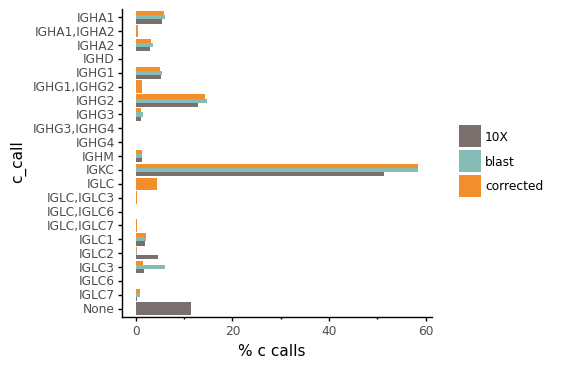

<ggplot: (305665637)>


Retrieving contant region calls, parallelizing with 4 cpus : 100%|██████████| 502/502 [00:00<00:00, 1302.30it/s]


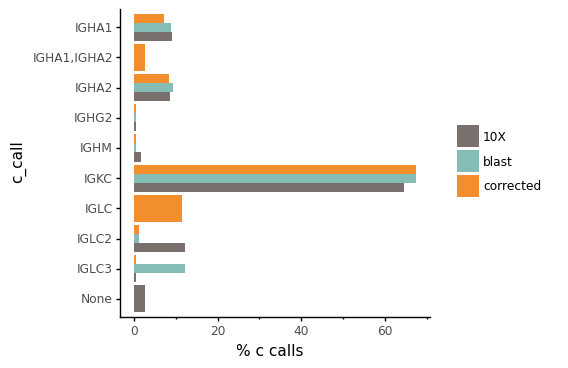

<ggplot: (307062357)>


Retrieving contant region calls, parallelizing with 4 cpus : 100%|██████████| 3835/3835 [00:40<00:00, 95.15it/s] 


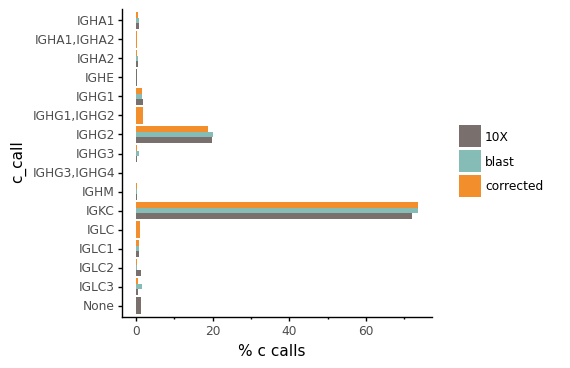

<ggplot: (310011577)>


Retrieving contant region calls, parallelizing with 4 cpus : 100%|██████████| 8651/8651 [02:53<00:00, 49.84it/s]


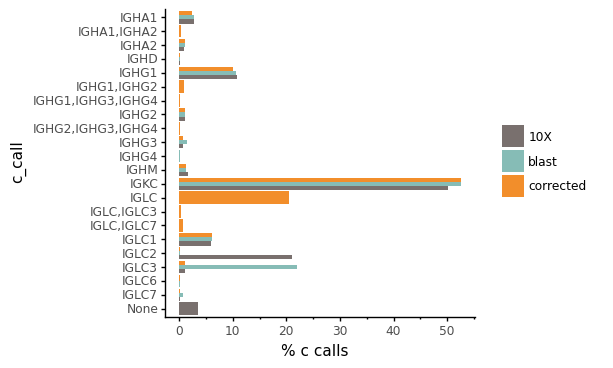

<ggplot: (307877381)>


Retrieving contant region calls, parallelizing with 4 cpus : 100%|██████████| 10213/10213 [04:11<00:00, 40.59it/s]


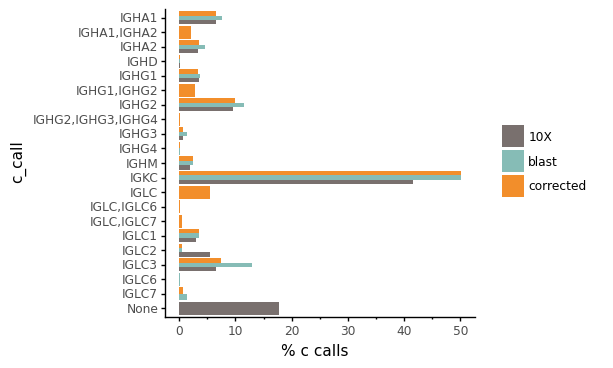

<ggplot: (306080825)>


Retrieving contant region calls, parallelizing with 4 cpus : 100%|██████████| 32052/32052 [38:21<00:00, 13.92it/s]


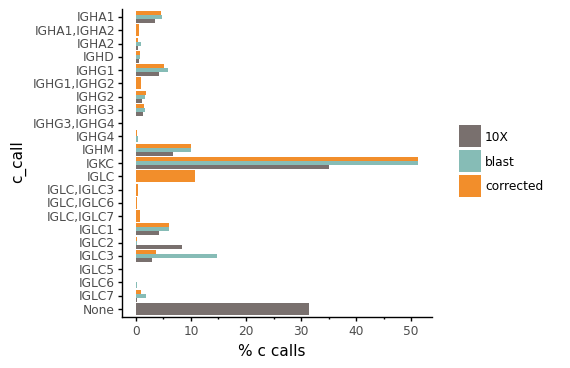

<ggplot: (317300717)>


Retrieving contant region calls, parallelizing with 4 cpus : 100%|██████████| 10880/10880 [05:21<00:00, 33.80it/s]


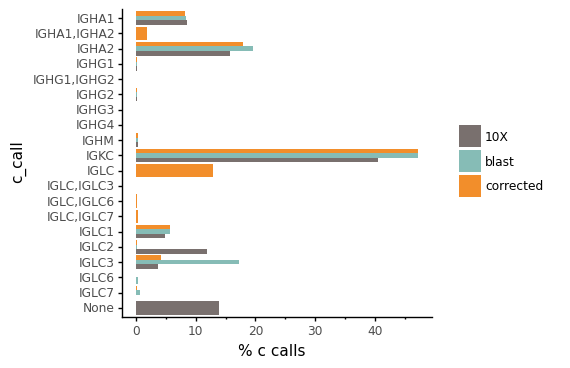

<ggplot: (309989577)>


Retrieving contant region calls, parallelizing with 4 cpus : 100%|██████████| 3374/3374 [00:32<00:00, 104.10it/s]


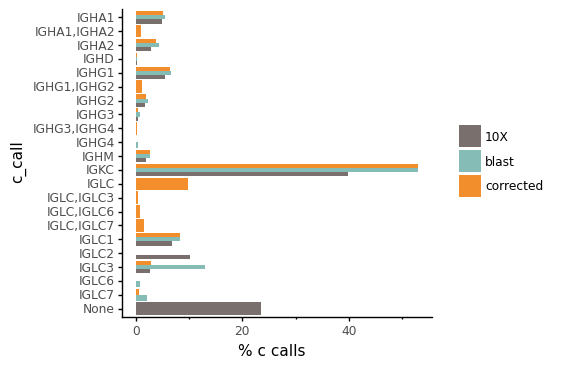

<ggplot: (309773253)>


Retrieving contant region calls, parallelizing with 4 cpus : 100%|██████████| 4656/4656 [01:16<00:00, 60.80it/s]


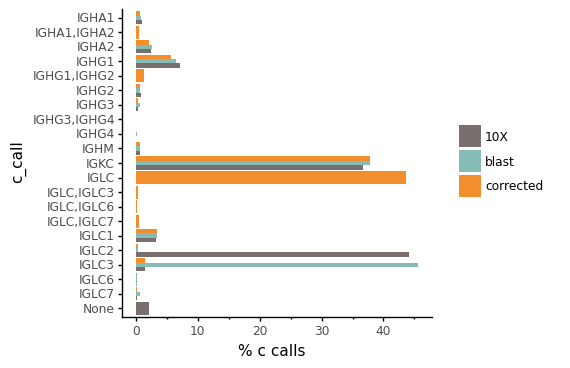

<ggplot: (308722853)>


Retrieving contant region calls, parallelizing with 4 cpus : 100%|██████████| 5352/5352 [01:29<00:00, 59.87it/s]


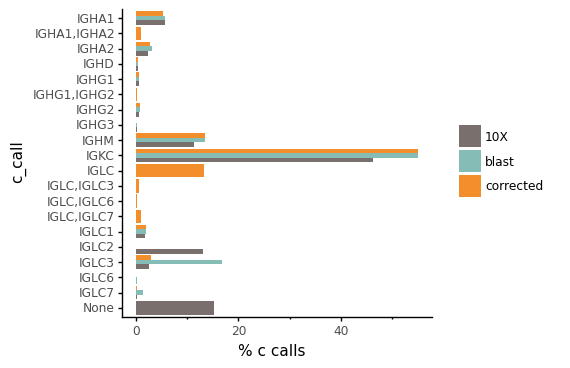

<ggplot: (309461653)>


Retrieving contant region calls, parallelizing with 4 cpus : 100%|██████████| 10922/10922 [03:43<00:00, 48.97it/s]


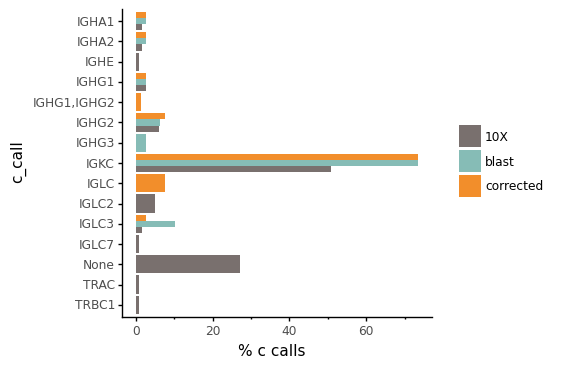

<ggplot: (317670533)>


Retrieving contant region calls, parallelizing with 4 cpus : 100%|██████████| 16829/16829 [12:52<00:00, 21.78it/s]


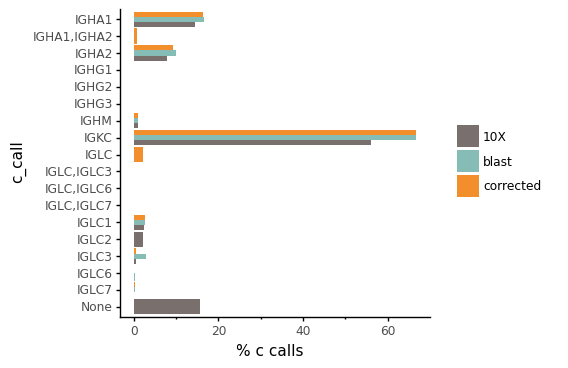

<ggplot: (308195641)>


Retrieving contant region calls, parallelizing with 4 cpus : 100%|██████████| 18745/18745 [11:54<00:00, 26.23it/s]


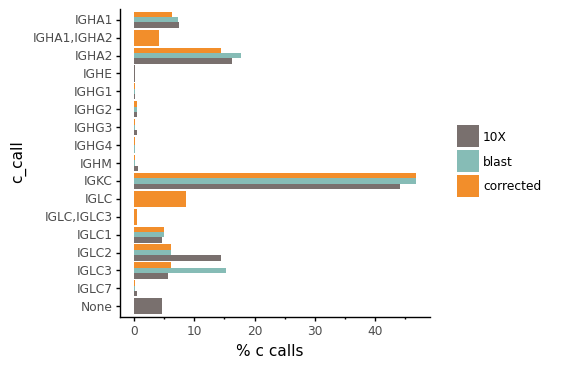

<ggplot: (306281137)>


In [6]:
for s in samples:
    filePath = s+'/dandelion/data/all_contig.fasta'
    ddl.pp.assign_isotype(filePath)

This still takes a while when dealing with large files; the number of cpus to size of file isn't exactly linear. Nevertheless, I have enabled parallelization as default because there were noticeable improvements in processing speeds with the smaller files. Maybe it will work better on a cluster with more cpus, rather than just a standard laptop. Other than a couple of samples that took about ***~10-40min***, most ran within ***2-5min***. I expect that this should run faster with filtered files too. The default option will return a summary plot that can be disabled with `plot = False`. Also, the function can be run with can be run with `fileformat = 'changeo'` if preferred.

It's worthwhile to manually check the the sequences for constant calls returned as IGHA1-2, IGHG1-4 and the light chains and manually correct them if necessary.

### Step 4 *(optional but recommended)*:
#### Reassigning heavy chain V gene alleles.

Last step for part one of pre-processing is to use *immcantation-tigger*'s method to reassign allelic calls for heavy chain V genes with `pp.reassign_alleles`. As stated in tigger's [website](https://tigger.readthedocs.io/en/stable/) and [manuscript](https://pubmed.ncbi.nlm.nih.gov/25675496/), *'TIgGER is a computational method that significantly improves V(D)J allele assignments by first determining the complete set of gene segments carried by an individual (including novel alleles) from V(D)J-rearrange sequences. TIgGER can then infer a subject’s genotype from these sequences, and use this genotype to correct the initial V(D)J allele assignments.'*

This impact's on how ***dandelion*** picks contigs to go forward for finding clones so it's highly recommended to run it. It's also important when considering to do mutational analysis. However, the main caveat is that this needs to be run on multiple samples from the same subject to allow for more information to be used to confidently assign a genotyped *v_call*. In this case, all the samples I have been processing above are BCR data from different organs of a single patient. So while important, this step can be skipped if you don't have the samples to do this. 

`pp.reassign_alleles` will call tigger and also run `pp.create_germlines` using the germline database updated with the germline corrections from tigger. The default behavior is that it will return a `germline_alignment_d_mask` column in the final output. This can be changed by specifying `germ_types` option; see [here](https://changeo.readthedocs.io/en/stable/tools/CreateGermlines.html#creategermlines) for other options.

Specifying `fileformat = 'changeo'` will run on changeo formatted files if this was run earlier; but it's probably best to stick to airr's standard format.

Processing data file(s) : 100%|██████████| 13/13 [00:01<00:00,  8.10it/s]


Concatenating objects
   Writing out concatenated object
      Reassigning alleles


   Returning light chain V calls: 100%|██████████| 36313/36313 [00:11<00:00, 3120.50it/s]
   Building dmask germline sequences: 36313it [01:05, 552.93it/s]


   Saving corrected genotyped object
Returning summary plot


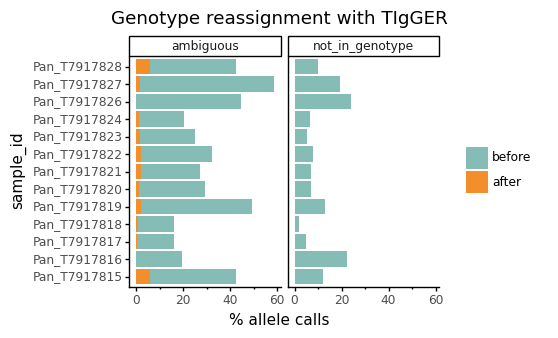

Writing out to individual folders :   0%|          | 0/13 [00:00<?, ?it/s]

<ggplot: (327857801)>


Writing out to individual folders : 100%|██████████| 13/13 [00:03<00:00,  3.90it/s]


In [7]:
# this is also a for loop for multiple samples from the same subject
ddl.pp.reassign_alleles(samples, out_folder = 'A31', sample_dict = sampledict)

We can see that most of the original ambiguous V calls have now been corrected and only a few remain. These will be flagged as multi later on and should probably be excluded from detailed analyses. For now, leaving them in the data will not impact on subsequent analyses. If the sample_dict option is not specified, I would reccomend to also specify the option `split_write_out = False`. This will return the results as a Dandelion object (to be covered in the 3rd notebook) like so:
```python
results = ddl.pp.reassign_alleles(samples, out_folder = 'A31', split_write_out = False)
```
You can then slice the `.data` slot like a typical pandas `DataFrame` object and save manually with `.to_csv`.